In [22]:
import pandas as pd
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [23]:
data_folder = "/home/lrbutler/Desktop/ELP_CNN_Spectrogram/data/"
meta_file = "nn_ele_hb_00-24hr_TrainingSet.txt"

In [24]:
data = pd.read_csv(os.path.join(data_folder, meta_file), delimiter='\t')
data.columns

Index(['Selection', 'View', 'Channel', 'Begin Time (s)', 'End Time (s)',
       'Low Freq (Hz)', 'High Freq (Hz)', 'Begin Path', 'File Offset (s)',
       'Begin File', 'Site', 'hour', 'fileDate', 'date(raven)', 'Tag 1',
       'Tag 2', 'notes', 'Analyst', 'Begin Path - old'],
      dtype='object')

# Distribution of the Length of the Labeled Signals

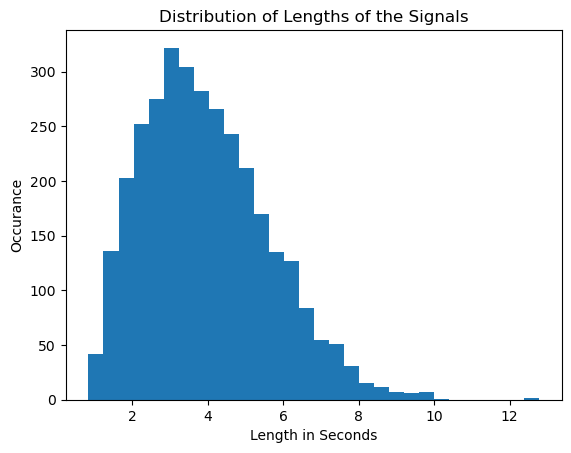

In [25]:
lengths = data['End Time (s)'] - data['Begin Time (s)']
plt.hist(lengths, bins=30)
plt.xlabel("Length in Seconds")
plt.ylabel("Occurance")
plt.title("Distribution of Lengths of the Signals")
plt.show()

# Distribution of Low and High Frequency Ranges

Text(0, 0.5, 'Occurance')

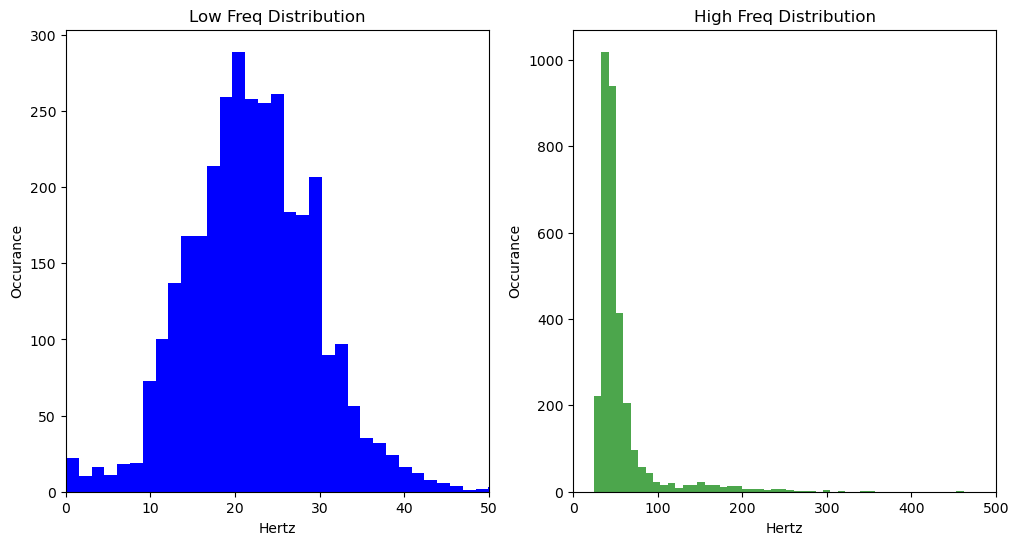

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot histograms
ax1.hist(data['Low Freq (Hz)'], bins=50, color='blue')
ax1.set_title('Low Freq Distribution')
ax1.set_xlim([0, 50])
ax1.set_xlabel('Hertz')
ax1.set_ylabel('Occurance')

ax2.hist(data['High Freq (Hz)'], bins=50, alpha=0.7, color='green')
ax2.set_title('High Freq Distribution')
ax2.set_xlim([0, 500])
ax2.set_xlabel('Hertz')
ax2.set_ylabel('Occurance')

In [27]:
from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

Opening file: /home/lrbutler/Desktop/ELP_CNN_Spectrogram/data/nn01a_20180126_000000.wav
9
21.1 49.7


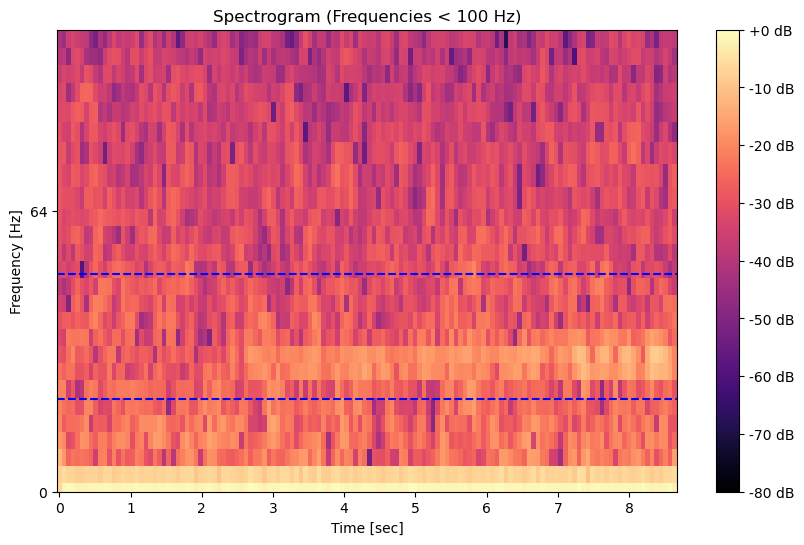

18.0 47.9


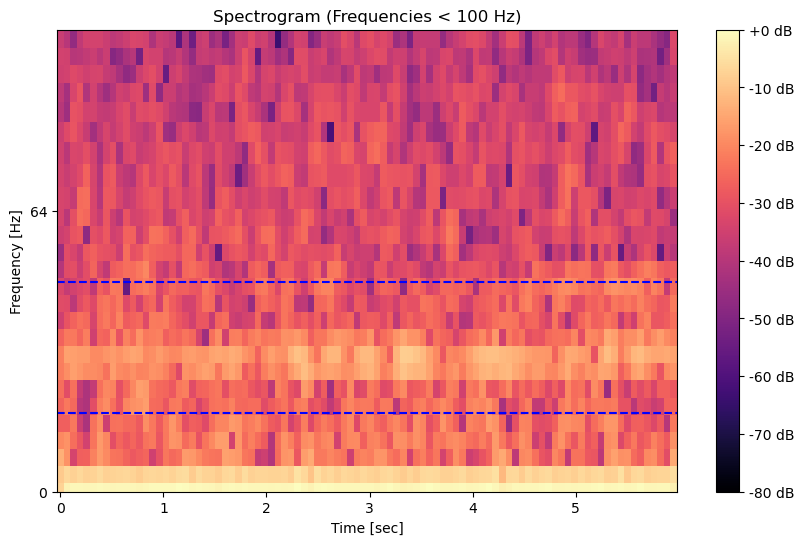

18.0 49.7


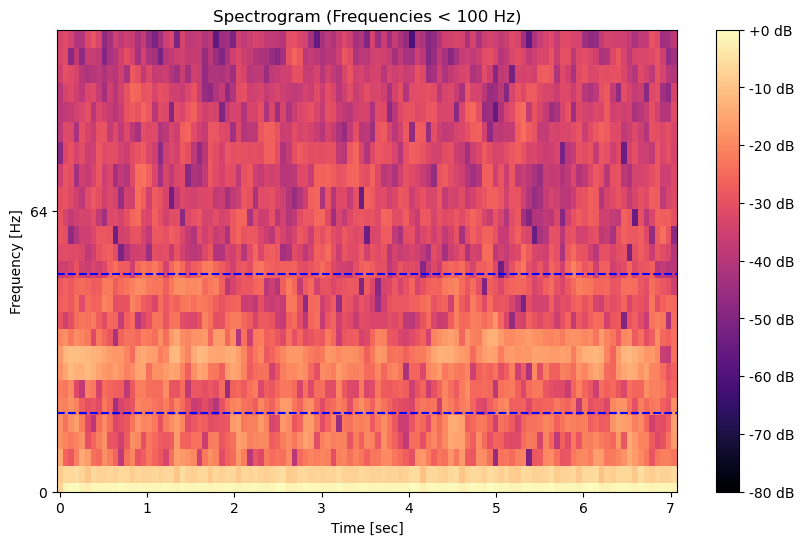

13.7 58.1


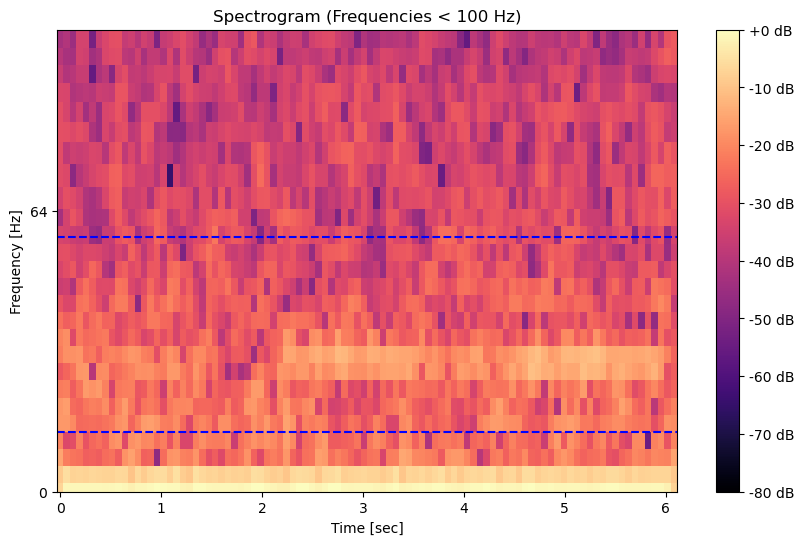

16.9 57.1


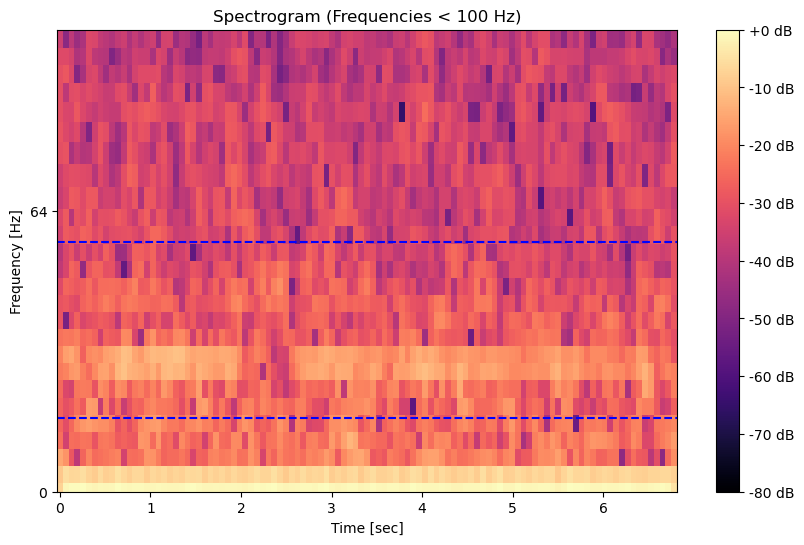

8.5 57.1


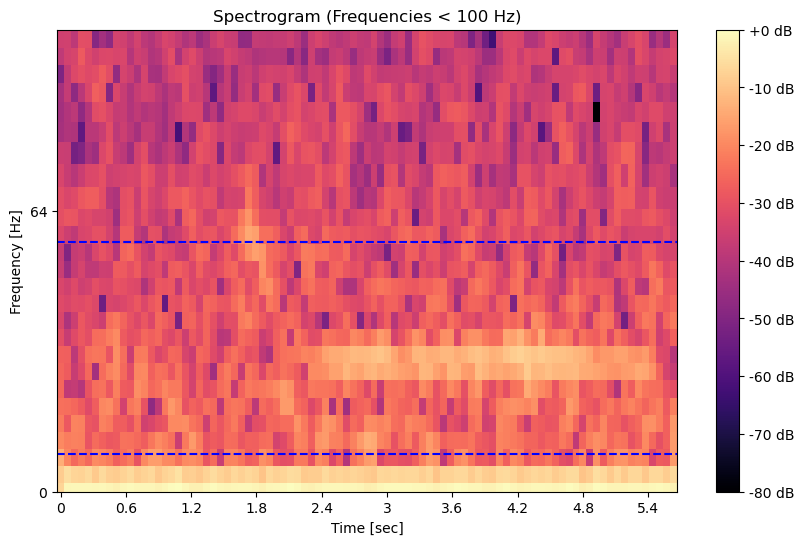

18.0 51.5


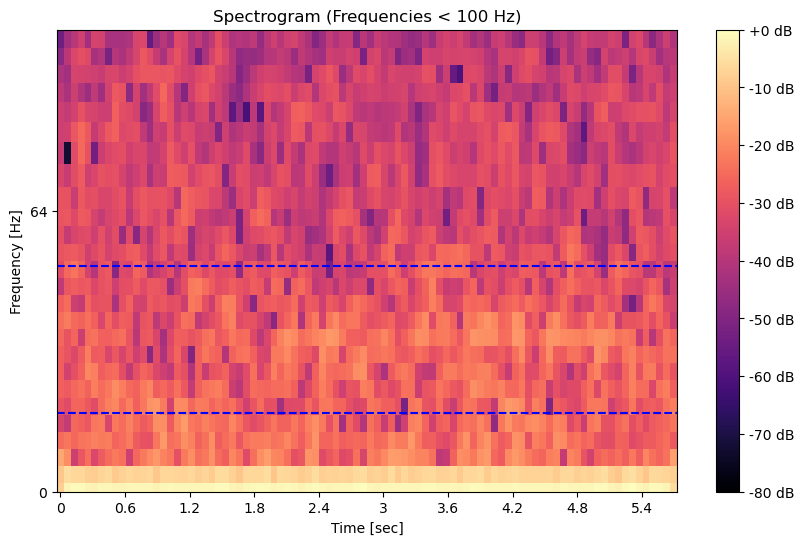

16.9 46.5


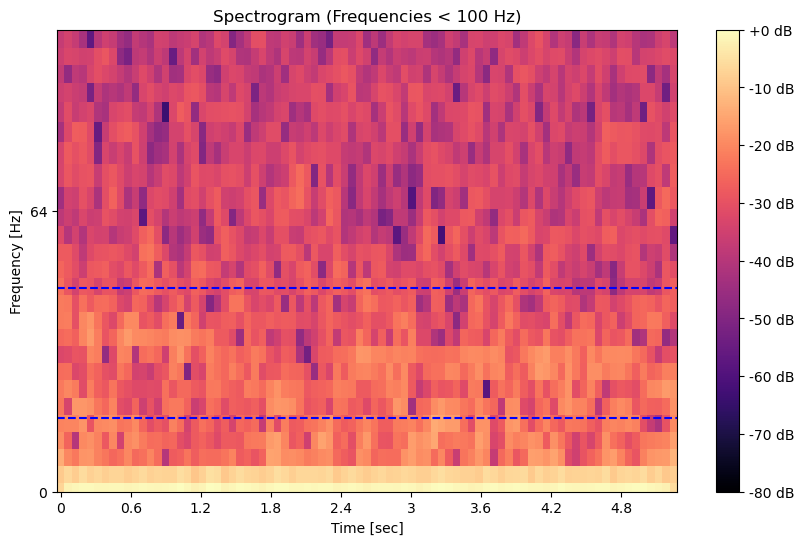

12.7 50.7


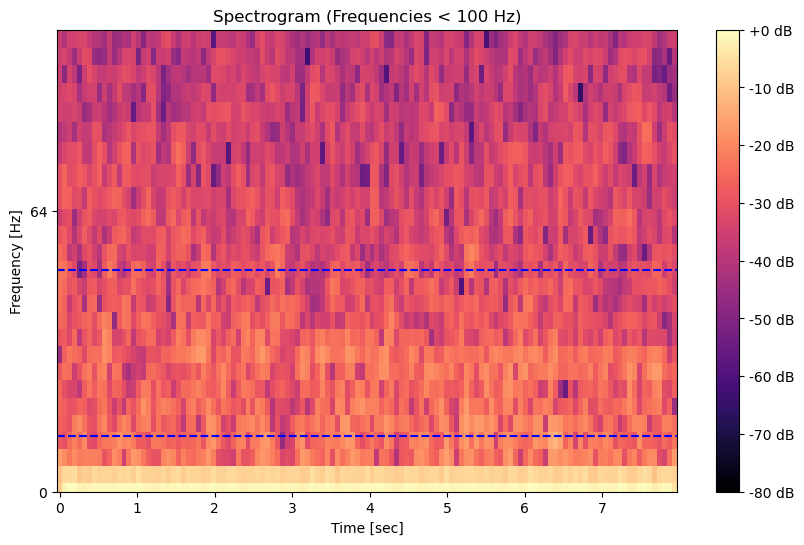

In [28]:
cutoff_frequency = 100  # Cutoff frequency for the low-pass filter
clip_length = 20 # Seconds


for file in set(data['Begin File']):
    target_file = os.path.join(data_folder, file)

    if os.path.exists(target_file):
        print(f"Opening file: {target_file}")

        audio, sampling_rate = librosa.load(target_file, sr=None)  # Use the default sampling rate

        clips = data[data['Begin File'] == file]

        print(len(clips))
        for offset, start, stop, low, high in zip(clips['File Offset (s)'], clips['Begin Time (s)'], clips['End Time (s)'], clips['Low Freq (Hz)'], clips['High Freq (Hz)']):
            
            starting_pos = int(offset) - 2
            stopping_pos = offset + (stop - start)

            selection_start, selection_end = int(2 * sampling_rate), int((2 + (stop - start)) * sampling_rate)
            begin_index, end_index = int(starting_pos * sampling_rate), int(stopping_pos * sampling_rate)

            audio_clip = audio[begin_index: end_index]
            audio_clip = lowpass_filter(audio_clip, cutoff_frequency, sampling_rate)


            # Create a mel-spectrogram
            signal_stft = librosa.stft(audio_clip)
            S_db = librosa.amplitude_to_db(abs(signal_stft), ref=np.max)

            # Display the spectrogram
            plt.figure(figsize=(10, 6))
            librosa.display.specshow(S_db, sr=sampling_rate, x_axis="time", y_axis='log')
            plt.colorbar(format='%+2.0f dB')
            plt.title('Spectrogram (Frequencies < 100 Hz)')
            plt.xlabel('Time [sec]')
            plt.ylabel('Frequency [Hz]')
            plt.ylim(0, 100)  # Set the y-axis limit to show frequencies under 100 Hz

            print(low, high)
            plt.axhline(y=low, color='blue', linestyle='--', label=f'Low Freq: {low} Hz')
            plt.axhline(y=high, color='blue', linestyle='--', label=f'High Freq: {high} Hz')

            # plt.axvline(x=selection_start, color='blue', linestyle='--', label=f'Stop Time: {stop} sec')
            # plt.axvline(x=selection_end, color='blue', linestyle='--', label=f'Stop Time: {stop} sec')


            plt.show()
            